# Assignment 3, Jakub Tłuczek
### Deep Learning 2023, UniBE

### BLUE TRAIN 78.85
### BLUE VALID 68.20

Importing all necessary libraries and functions:

In [1]:
import os 
import json
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from utils import save_checkpoint, load_checkpoint, print_examples, CustomScheduler
from get_loader import get_loader, build_vocab
from get_loader import transform_data as transform
from model import CNNtoRNN, VITtoDT
from evaluate import evaluate_dataset_new
import math
import torchvision.models as models
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from get_loader import transform_data as transform
import numpy as np
from textwrap import wrap
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Architecture

To solve this task I've decided to implement following architecture:

![transformer_diagram](transformer2.svg )

As an encoder I've used `vit_b_16` model, available in `torchvision` library. It comes with several pretrained weights, I've used the default ones, trained on the ImageNet. ViT, or Vision Transformer has been described in "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" [Dosovitskiy et al, 2020](https://arxiv.org/abs/2010.11929). Main idea is to divide the image into evenly shaped patches (in this case 16x16), compute the embeddings of patch (convoluted and flattened), position and class, and then feed it into the transformer encoder. Output is then passed into the MLP head, which maps the encoding into number of classes. 

During training, I fine-tuned the encoder by optimizing only the MLP head and the linear layer immediately afterwards. I had also tried training whole encoder (without convolution layers), however it was not beneficial either to the metric value or the training time. Due to the fact that I used pretrained weights and I had little possibility to affect structure of the encoder part, I had implemented a linear layer on top of that, which would map output of ViT block (and its MLP head) to the size of embedding. Results of linear layer were passed through rectified linear unit and dropout layer before being passed as a memory input into cross attention layers in decoder. 

Decoder has been trained from the beginning. It is based on a default transformer decoder block described in "Attention is all you need" [Vaswani et al 2017](https://arxiv.org/pdf/1706.03762.pdf). First, caption (without `<EOS>` token) is turned into an embedding and positional embedding is added. Then it is passed to the decoder, consisting of 4 layers with 8 heads each. Output from the encoder is used as a memory input. Expected output is an initial caption without `<SOS>` tag, which essentialy means that transformer learns how to shift the sentence by one place to the left. It is essential in the context of inference - given only `<SOS>` token and encoded image it will learn to output word by word with every inference iteration until it outputs `<EOS>` - then inference is stopped and results is an embedding of a result caption. I additionally added a linear layer on top of decoder. However, I didn't have to use softmax layer, as the loss function I use, `nn.CrossEntropyLoss` already computes logits from raw outputs. In decoder I have also used a mask to prevent the model from attending the next tokens. It is a square matrix where upper part has value `-inf`.

In [2]:
# source of the code for positional encoding: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 50):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    

class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, heads, dropout):
        super(DecoderTransformer, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.pos_en = PositionalEncoding(hidden_size, max_len=embed_size)
        self.decoder_layer = nn.TransformerDecoderLayer(hidden_size, heads, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        # permuting captions to form [batch size, caption size]
        cpt_per = torch.permute(captions, (1,0)).to(device)
        emb = self.embed(cpt_per)
        pos_emb = self.pos_en(emb)
        # permuting to get batch first
        pos_emb = torch.permute(pos_emb, (1,0,2)).to(device)
        # applying subsequent mask to avoid looking forward
        mask = nn.Transformer.generate_square_subsequent_mask(pos_emb.size(1), device=device)
        dec_out = self.decoder(tgt=pos_emb, memory=features, tgt_mask=mask)
        outputs = self.linear(dec_out)
        return outputs

class EncoderVIT(nn.Module):
    def __init__(self, embed_size):
        super(EncoderVIT, self).__init__()
        # loading pre-trained weights
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        self.fc = nn.Linear(self.vit.num_classes, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.fc(self.vit(images))
        return self.dropout(self.relu(features)).view(features.size(0), 1, features.size(1))
    

class VITtoDT(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, heads, dropout):
        super(VITtoDT, self).__init__()
        self.encoder = EncoderVIT(embed_size)
        self.decoder = DecoderTransformer(embed_size, hidden_size, vocab_size, num_layers, heads, dropout)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = None

        with torch.no_grad():
            img_enc = self.encoder(image.unsqueeze(0))
            sos_id = vocabulary.stoi["<SOS>"]
            sentence = torch.tensor([sos_id]).unsqueeze(0).to(device)

            for _ in range(max_length):
                output = self.decoder(img_enc, sentence)
                # getting last word in output as a predicted one
                predicted = output[:,-1,:].argmax(1).unsqueeze(0).to(device)
                sentence = torch.cat((sentence,predicted), 1).to(device)
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
            result_caption = sentence

        return [vocabulary.itos[idx.item()] for idx in result_caption.flatten() 
                if idx not in  [vocabulary.stoi["<SOS>"], vocabulary.stoi["<EOS>"], vocabulary.stoi["."]]]


### Training details

Training is a modified version of what I was supplied with in the beginning. Due to the memory constraints of the graphic card I had to reduce batch size to 128 - it meant more frequent gradient updates, so the overall number of epochs is lower than 300 in case of first benchmark of `CNNtoRNN`. I've increased both embedding size and hidden size to 512, I had used eight heads in each decoder layer. I had also used the gradient clipping, to prevent them from exploding. I didn't use the teacher forcing.

Moreover, I've included learning rate scheduler, additional optimizer parameters and label smoothing as described in "Attention Is All You Need" and [this implementation](https://kikaben.com/transformers-training-details). 

Learning rate is computed as follows: 

$lr = \frac{1}{\sqrt{d_{model}}} * min(\frac{1}{\sqrt{step\_num}}, step\_num * \frac{1}{warmup\_steps^{\frac{3}{2}}})$

where $d_{model}$ is the hidden dimension, $step\_num$ current number of step, and $warmup\_steps$ a number of warmup steps, which I set to 4000.

To optimize, I've used Adam optimizer with the same parameters as autors of the paper, that is $\beta_1 = 0.9$, $\beta_2 = 0.98$ and $\epsilon = 10^{-9}$.

Label smoothing is integrated into PyTorch implementation of Cross Entropy Loss, which I use, and it essentialy means that correct token get's $1 - smoothing$ for its probability, and for all other choices $smoothing$ is distributed uniformly. This regularization in principle should prevent model from fast overfitting, and to be more general once it sees the validation and test data.

The parameter that I tweaked a little is the dropout. I've tried several values, which I will describe in the next section.

Due to the fact that I always permute the tensors to have batch in the first dimension for readability purposes, I had to modify a little the evaluation script and switch the dimensions there. 

Generally speaking I've noticed that in every instance my architecture tends to overfit, with validation BLEU being more or less on the same level. I have also noticed that the evaluation itself is to some extent a stochastic process, due to the random crop in the transformations. Evaluating the same picture few times in a row might result in different captions, thus possibly in different metric values. I have also taken that into account while picking the best model. 

Training had been conducted entirely on device 0 on node 14 of the cluster in the days I had assigned. Each time I had run the `train.py` file, which for purpose of this notebook I had to transfer here, along with functions declared in `models.py` and `utils.py`. I've also slightly modified `evaluate.py` to match my dimensions.

In [3]:
# source: kikaben.com/transformers-training-details
class CustomScheduler(_LRScheduler):
    def __init__(self, optimizer: Optimizer, dim_embed: int, warmup_steps: int, last_epoch: int=-1, verbose: bool=False):
        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)
        super().__init__(optimizer, last_epoch, verbose)
    
    def get_lr(self):
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups

def calc_lr(step, dim_embed, warmup_steps):
    return dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))

In [5]:
vocab = build_vocab("../../flickr8k_split/captions.txt", freq_threshold = 5)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True
train_encoder = False

In [6]:
# Hyperparameters
batch_size = 128
embed_size = 512
hidden_size = 512
vocab_size = len(vocab)
num_layers = 4
learning_rate = 1e-4
num_epochs = 101
heads = 8
dropout = 0.5


In [7]:

run_name = 'vit_to_dt_ft5'
output_dir = os.path.join('checkpoints', run_name)
os.makedirs(output_dir , exist_ok= True)
step = 0

train_loader, dataset = get_loader(
    root_folder="../../flickr8k_split/train_images",
    annotation_file="../../flickr8k_split/train_captions.txt",
    transform=transform,
    vocab = vocab, # None
    num_workers=8,
    batch_size = batch_size
)


val_loader, _ = get_loader(
    root_folder="../../flickr8k_split/val_images",
    annotation_file="../../flickr8k_split/val_captions.txt",
    transform=transform,
    vocab = vocab, #dataset.vocab,
    num_workers=1,
    batch_size = 5,
    shuffle = False,
) 

train_loader_eval, _ = get_loader(
    root_folder="../../flickr8k_split/train_images",
    annotation_file="../../flickr8k_split/train_captions.txt",
    transform=transform,
    vocab = vocab, # None
    num_workers=1,
    batch_size = 5, # each image has 5 different GT captions, for each batch we will load only one image and corresponding captions
    shuffle = False,
)

model = VITtoDT(embed_size, hidden_size, vocab_size, num_layers, heads, dropout).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"], label_smoothing=0.1) # it will ignore 'PAD' words 
optimizer = optim.Adam(model.parameters(), betas = (0.9, 0.98), eps=1.0e-9)
scheduler = CustomScheduler(optimizer, embed_size, 4000)

for name, param in model.encoder.named_parameters():
    if "encoder.ln" in name or "heads.head" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_encoder

In [ ]:
if load_model:
    step = load_checkpoint(torch.load('./checkpoints/vit_to_dt_4/checkpoints_40.pth.tar'), model, optimizer)


In [ ]:
model.train()
for epoch in range(num_epochs):
    # Uncomment the line below to see a couple of test cases
    if epoch % 5 == 0: # modify for your case
        print_examples(model, device, dataset)
    
    if epoch % 5 ==0: # modify for your case
        # calculate BLUE score on the validation set
        blue_score_val = evaluate_dataset_new(model, val_loader, vocab, device)
        print('BLUE SCORES validation ', epoch, blue_score_val)
        # calculate BLUE score on the training set
        blue_score_train = evaluate_dataset_new(model, train_loader_eval, vocab, device)
        print('BLUE SCORES TRAIN', epoch, blue_score_train)
        
        # logging
        log_stats = {'BLUE-1-VAL': blue_score_val,
                     'BLUE-1-TRAIN': blue_score_train,
                    'epoch': epoch}
        f = open(os.path.join(output_dir, "log_blue.txt"), "a+")
        f.write(json.dumps(log_stats) + "\n")
        f.close()

        # save model every epoch - modify it you do not want to save it every epoch
    if save_model and epoch % 5 == 0 and epoch > 0:
      checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
		        "lr": scheduler.optimizer.param_groups[0]['lr'],
      }
      save_checkpoint(checkpoint, filename = os.path.join(output_dir, 'checkpoints_'+str(epoch)+'.pth.tar'))
    
    for idx, (imgs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False
    ):

        imgs = imgs.to(device)
        captions = captions.to(device)
        outputs = model(imgs, torch.permute(captions[:-1], (1,0)))
        loss = criterion(
            torch.permute(outputs, (0,2,1)), torch.permute(captions[1:], (1,0))
        )
        step += 1

        optimizer.zero_grad()
        loss.backward(loss)
        # use clip grad if needed
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 10.)
        optimizer.step()

        scheduler.step()
        # logging
        log_stats = {'loss': loss.item(),
                    'epoch': epoch,
                    'step': step, 'lr':scheduler.optimizer.param_groups[0]['lr']}
        f = open(os.path.join(output_dir, "log_loss.txt"), "a+")
        f.write(json.dumps(log_stats) + "\n")
        f.close()
    print("Training loss", loss.item(), epoch)


### Results

In total I had trained 4 models:

- entire model except convolution layers in encoder, with pretrained weights, dropout=0.3
- fine-tuned encoder, dropout=0.3
- fine-tuned encoder, dropout=0.4
- fine-tuned encoder, dropout=0.5

#### No finetuning

This model resulted in enormous training times and had to had its batch size reduced to 32, just to be able to fit into memory. Encoder, having 12 layers added a lot of parameters to optimize, yet no visible performance gains were achieved. This model broke only first threshold, stopping just short of the second one. Below is the visualization of loss and BLEU score:

In [8]:
nofinetune_loss = pd.read_json('17maj_nofinetunebig/log_loss.txt', lines=True)
nofinetune_loss['loss_moving'] = nofinetune_loss['loss'].rolling(300, min_periods=1).mean()
nofinetune_loss.head()

,loss,epoch,step,lr,loss_moving
0,8.129903,0,1,3.493856e-07,8.129903
1,8.177691,0,2,5.240784e-07,8.153797
2,8.136791,0,3,6.987712e-07,8.148128
3,8.133911,0,4,8.734641e-07,8.144574
4,8.180168,0,5,1.048157e-06,8.151693


In [9]:
nofinetune_bleu = pd.read_json('17maj_nofinetunebig/log_blue.txt', lines=True)
nofinetune_bleu.head()

,BLUE-1-VAL,BLUE-1-TRAIN,epoch
0,0.333930,0.349100,0
1,60.435551,62.454898,2
2,60.787102,62.506303,4
3,63.068704,65.213300,6
4,63.571689,67.350459,8


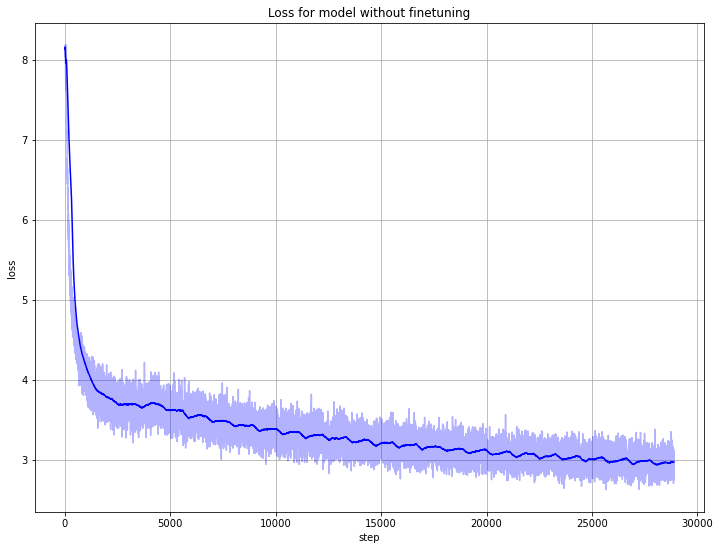

In [10]:
plt.figure(figsize=(12,9))
plt.plot(nofinetune_loss['loss'], color='b', alpha=0.3)
plt.plot(nofinetune_loss['loss_moving'], color='b')
plt.title("Loss for model without finetuning")
plt.xlabel("step")
plt.ylabel("loss")
plt.grid()

For better readability I won't plot initial BLEU scores, which are close to zero.

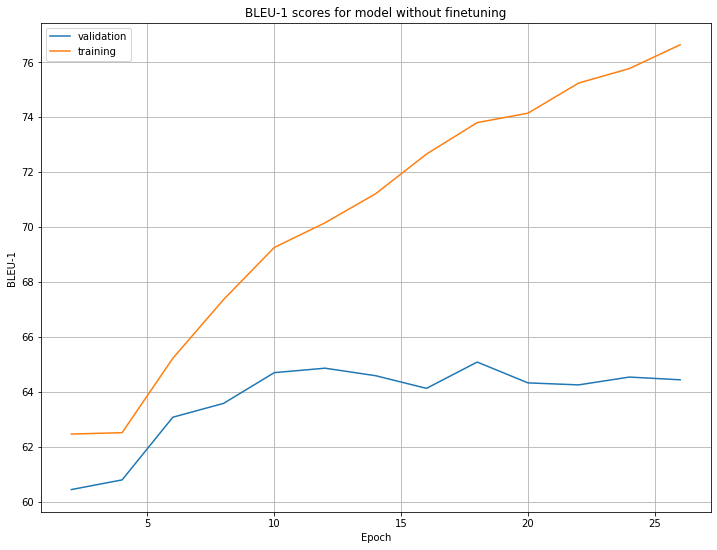

In [11]:
plt.figure(figsize=(12,9))
plt.plot(nofinetune_bleu['epoch'][1:], nofinetune_bleu['BLUE-1-VAL'][1:], label="validation")
plt.plot(nofinetune_bleu['epoch'][1:], nofinetune_bleu['BLUE-1-TRAIN'][1:], label='training')
plt.legend()
plt.title("BLEU-1 scores for model without finetuning")
plt.xlabel("Epoch")
plt.ylabel("BLEU-1")
plt.grid()

As it can be noticed this model overfits the data. The best validation score was achieved at epoch 18, with validation BLEU-1 of 65.08%, and training BLEU-1 of 73.79%.

#### Finetuning

These models were trained with only finetuning the encoder and training its MLP head together with linear layer just afterwards. They have different value of dropout, namely 0.3, 0.4 and 0.5. I'll refer to them as FT3, FT4 and FT5 respectively. Each model has been trained for 70 epochs.

In [12]:
ft3_loss = pd.read_json('18maj_finetunebig/log_loss.txt', lines=True)
ft3_bleu = pd.read_json('18maj_finetunebig/log_blue.txt', lines=True)
ft3_loss = ft3_loss[ft3_loss['epoch'] < 70]

As FT4 was trained in two sessions, I have to join the results, and discard those beyond last saved checkpoint

In [13]:
ft4_loss = pd.read_json('20maj_finetune0_4/log_loss.txt', lines=True)
ft4_bleu = pd.read_json('20maj_finetune0_4/log_blue.txt', lines=True)
ft4_loss_bis = pd.read_json('20maj_finetune0_4/continued/log_loss.txt', lines=True)
ft4_bleu_bis = pd.read_json('20maj_finetune0_4/continued/log_blue.txt', lines=True)
ft4_loss = ft4_loss[ft4_loss['epoch'] < 45]
ft4_loss_bis['epoch'] = ft4_loss_bis['epoch'] + 45
ft4_bleu_bis['epoch'] = ft4_bleu_bis['epoch'] + 45
ft4_loss = ft4_loss.append(ft4_loss_bis, ignore_index=True)
# ignoring repeated measurement for one row by filtering out double value for 45th epoch
ft4_bleu = ft4_bleu.append(ft4_bleu_bis[ft4_bleu_bis['epoch'] > 45], ignore_index=True)
ft4_loss = ft4_loss[ft4_loss['epoch'] < 70]

/tmp/ipykernel_16779/3722635371.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ft4_loss = ft4_loss.append(ft4_loss_bis, ignore_index=True)
/tmp/ipykernel_16779/3722635371.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ft4_bleu = ft4_bleu.append(ft4_bleu_bis[ft4_bleu_bis['epoch'] > 45], ignore_index=True)


In [14]:
ft5_loss = pd.read_json('19maj_finetune0_5/log_loss.txt', lines=True)
ft5_bleu = pd.read_json('19maj_finetune0_5/log_blue.txt', lines=True)
ft5_loss = ft5_loss[ft5_loss['epoch'] < 70]

First, let's plot how does the learning rate change, using the scheduler I defined earlier:

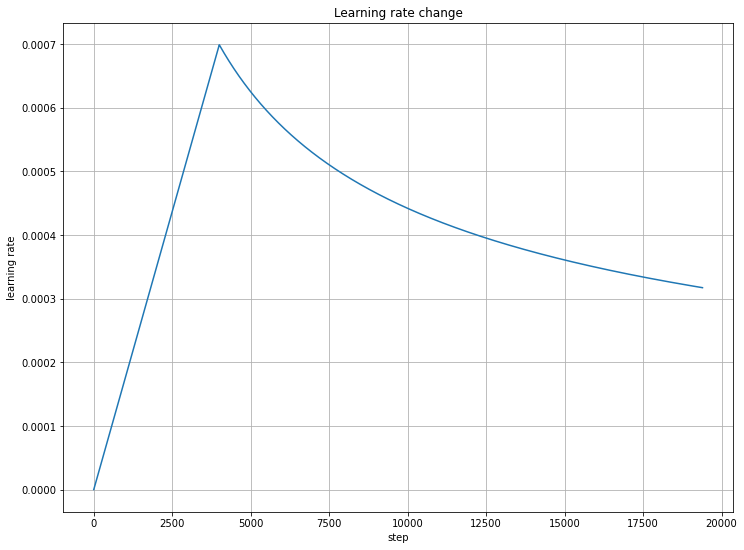

In [15]:
plt.figure(figsize=(12,9))
plt.plot(ft3_loss['lr'])
plt.title("Learning rate change")
plt.xlabel('step')
plt.ylabel('learning rate')
plt.grid()

It goes from 0 to the maximum value during warmup period, and then dampens slowly

Alongside opaque loss values I will plot the rolling average with the window of 300 measurements, to smoothen the curve.

In [16]:
ft3_loss['loss_moving'] = ft3_loss['loss'].rolling(300, min_periods=1).mean()
ft4_loss['loss_moving'] = ft4_loss['loss'].rolling(300, min_periods=1).mean()
ft5_loss['loss_moving'] = ft5_loss['loss'].rolling(300, min_periods=1).mean()

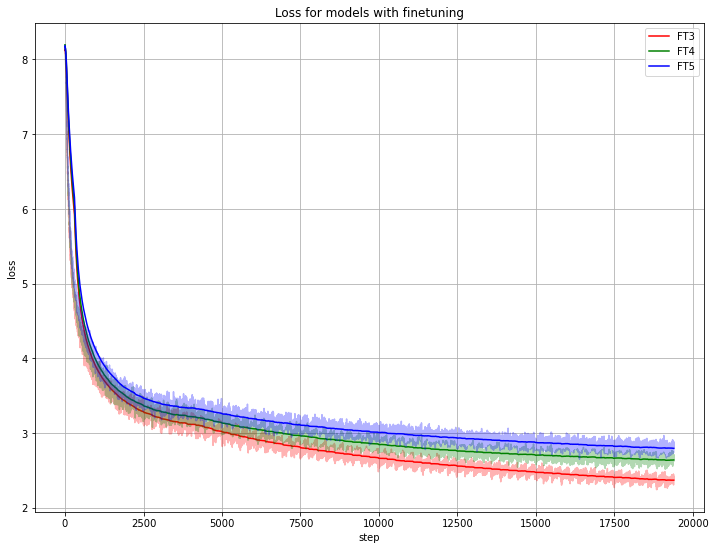

In [17]:
plt.figure(figsize=(12,9))
plt.plot(ft3_loss['loss'], color='r', alpha=0.3)
plt.plot(ft3_loss['loss_moving'], color='r', label='FT3')
plt.plot(ft4_loss['loss'], color='g', alpha=0.3)
plt.plot(ft4_loss['loss_moving'], color='g', label='FT4')
plt.plot(ft5_loss['loss'], color='b', alpha=0.3)
plt.plot(ft5_loss['loss_moving'], color='b', label='FT5')
plt.title("Loss for models with finetuning")
plt.xlabel("step")
plt.ylabel("loss")
plt.grid()
plt.legend()

Bigger the dropout, slower the loss falls down, which means that dropout has an effect on loss computation. Let's see if it also impacts the BLEU scores (training BLEU is depicted with dashed line, validation BLEU with solid one):

Text(0, 0.5, 'BLEU-1')

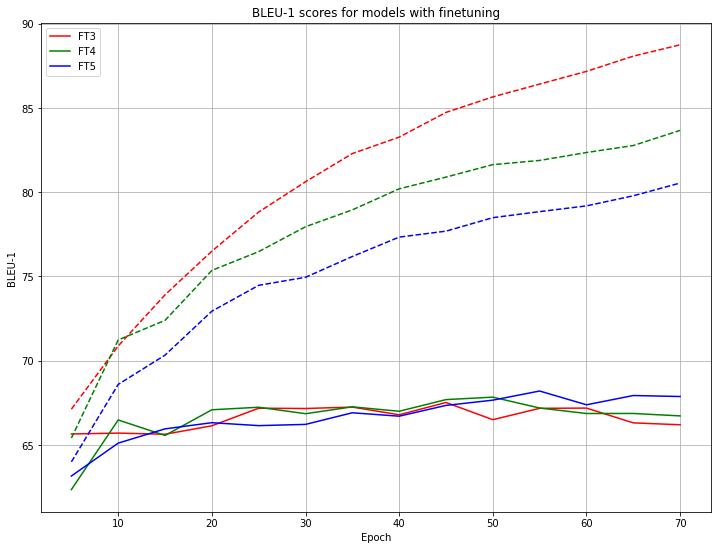

In [18]:
plt.figure(figsize=(12,9))
plt.plot(ft3_bleu['epoch'][1:], ft3_bleu['BLUE-1-VAL'][1:], color='r', label="FT3")
plt.plot(ft3_bleu['epoch'][1:], ft3_bleu['BLUE-1-TRAIN'][1:], color='r', linestyle='--')
plt.plot(ft4_bleu['epoch'][1:], ft4_bleu['BLUE-1-VAL'][1:], color='g', label="FT4")
plt.plot(ft4_bleu['epoch'][1:], ft4_bleu['BLUE-1-TRAIN'][1:], color='g', linestyle='--')
plt.plot(ft5_bleu['epoch'][1:], ft5_bleu['BLUE-1-VAL'][1:], color='b', label="FT5")
plt.plot(ft5_bleu['epoch'][1:], ft5_bleu['BLUE-1-TRAIN'][1:], color='b', linestyle='--')
plt.legend()
plt.grid()
plt.title("BLEU-1 scores for models with finetuning")
plt.xlabel("Epoch")
plt.ylabel("BLEU-1")

Overfitting still persists, however with bigger values of dropout the gap between training and validation BLEU-1 is smaller - also it produces slightly better validation scores, with FT5 peaking at **68,2%** in validation BLEU, having 78,85% in the training set. 

Results for highest validation scores and corresponding training scores are in the table below:

| Model | BLEU-1 TRAIN | BLEU-1 VAL | Epoch |
| ----- | ------------ | ---------- | ----- |
| FT3 | 84.73 | 67.52 | 45 |
| FT4 | 81.63 | 67.84 | 50 |
| FT5 | 78.85 | 68.20 | 55 |

For further evaluation I will consider checkpoint from 55th epoch of model FT5.

### Inference

In this section I will score the model on the test partition, as well as show few example captions on images previously unseen by the model.

In [19]:
model = VITtoDT(embed_size, hidden_size, vocab_size, num_layers, heads, dropout).to(device)
step = load_checkpoint(torch.load('../19maj_finetune0_5/checkpoints_55.pth.tar', map_location=torch.device('cpu')), model, optimizer)

=> Loading checkpoint


In [20]:
pictures = os.listdir('../../flickr8k_split/test_images/')

Scoring the model on the test images:

In [23]:
model.eval()
captions = {}
for picture in tqdm(pictures):
    img = Image.open(f'../../flickr8k_split/test_images/{picture}').convert("RGB")
    t_img = transform(img)
    result = model.caption_image(t_img.to(device), dataset.vocab)
    result = [w for w in result if w not in ('.', '<EOS>')]
    result = ' '.join(result)
    captions[picture] = result

  0%|          | 0/500 [00:00<?, ?it/s]/home/tluczekk/anaconda3/lib/python3.9/site-packages/torch/nn/modules/activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402323377/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
100%|██████████| 500/500 [06:22<00:00,  1.31it/s]


Saving the results to a text file with appropriate format

In [24]:
captions_df = pd.DataFrame.from_dict(captions, orient='index').reset_index()
captions_df.columns = ['image','caption']
captions_df = captions_df.sort_values(by=['image'])
captions_df = captions_df.set_index('image')
captions_df.head(10)

,caption
image,
130211457_be3f6b335d.jpg,two women in <UNK> are posing for a picture
131632409_4de0d4e710.jpg,a young girl in a bikini is standing on the beach
132489044_3be606baf7.jpg,a man in a black jacket is sitting on a red couch
133189853_811de6ab2a.jpg,a man and a woman are standing in front of a l...
133905560_9d012b47f3.jpg,a dog is running through the snow
134724228_30408cd77f.jpg,a man and a woman are standing on a grassy hill
134894450_dadea45d65.jpg,a boy in a white shirt and blue jeans is jumpi...
135235570_5698072cd4.jpg,a man in a red shirt is standing on a grassy f...
136552115_6dc3e7231c.jpg,a man on a bike is jumping over a hill


In [26]:
captions_df.to_csv('Jakub_Tluczek.txt')

Example captions given to the images from the test set:

Text(0.5, 1.0, 'a man in a white shirt and blue jeans is\nclimbing a rock wall')

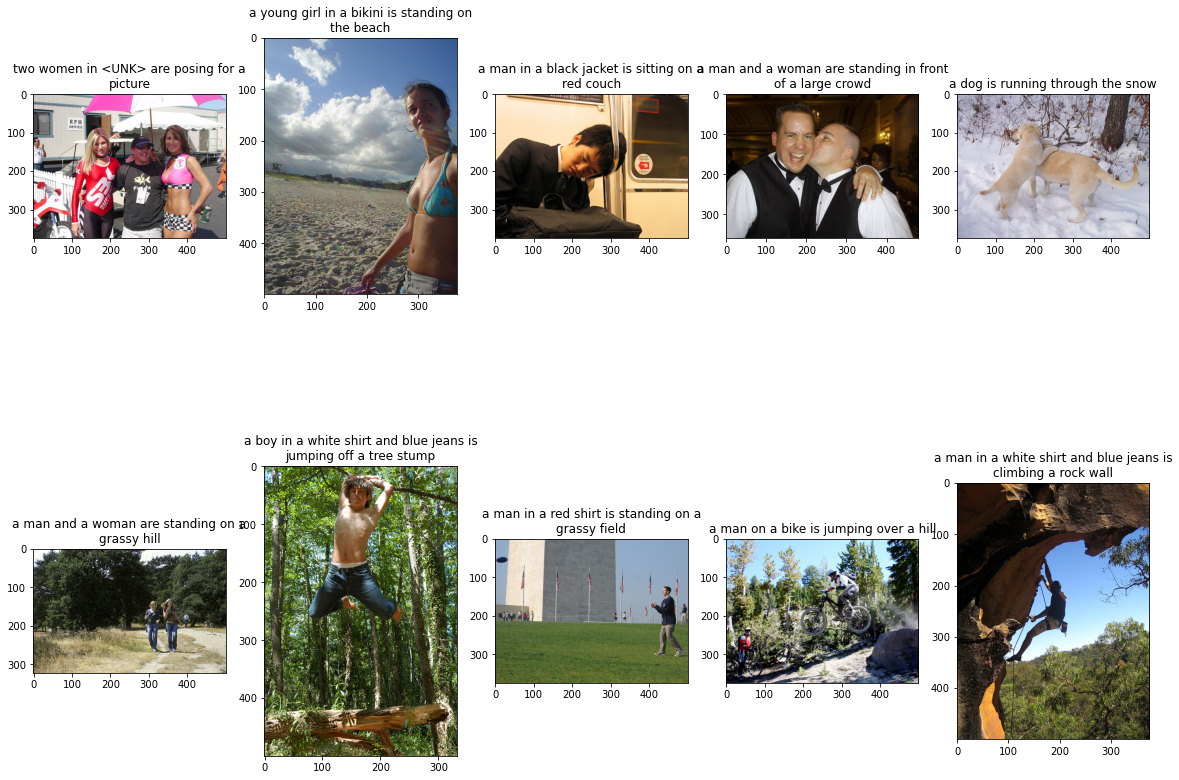

In [25]:
fig, axs = plt.subplots(2,5, figsize=(20,15))
img_name = '130211457_be3f6b335d.jpg'
img = np.asarray(Image.open(f'../../flickr8k_split/test_images/{img_name}'))
axs[0,0].imshow(img)
axs[0,0].set_title("\n".join(wrap(captions_df.loc[img_name]['caption'], 40)))
img_name = '131632409_4de0d4e710.jpg'
img = np.asarray(Image.open(f'../../flickr8k_split/test_images/{img_name}'))
axs[0,1].imshow(img)
axs[0,1].set_title("\n".join(wrap(captions_df.loc[img_name]['caption'], 40)))
img_name = '132489044_3be606baf7.jpg'
img = np.asarray(Image.open(f'../../flickr8k_split/test_images/{img_name}'))
axs[0,2].imshow(img)
axs[0,2].set_title("\n".join(wrap(captions_df.loc[img_name]['caption'], 40)))
img_name = '133189853_811de6ab2a.jpg'
img = np.asarray(Image.open(f'../../flickr8k_split/test_images/{img_name}'))
axs[0,3].imshow(img)
axs[0,3].set_title("\n".join(wrap(captions_df.loc[img_name]['caption'], 40)))
img_name = '133905560_9d012b47f3.jpg'
img = np.asarray(Image.open(f'../../flickr8k_split/test_images/{img_name}'))
axs[0,4].imshow(img)
axs[0,4].set_title("\n".join(wrap(captions_df.loc[img_name]['caption'], 40)))
img_name = '134724228_30408cd77f.jpg'
img = np.asarray(Image.open(f'../../flickr8k_split/test_images/{img_name}'))
axs[1,0].imshow(img)
axs[1,0].set_title("\n".join(wrap(captions_df.loc[img_name]['caption'], 40)))
img_name = '134894450_dadea45d65.jpg'
img = np.asarray(Image.open(f'../../flickr8k_split/test_images/{img_name}'))
axs[1,1].imshow(img)
axs[1,1].set_title("\n".join(wrap(captions_df.loc[img_name]['caption'], 40)))
img_name = '135235570_5698072cd4.jpg'
img = np.asarray(Image.open(f'../../flickr8k_split/test_images/{img_name}'))
axs[1,2].imshow(img)
axs[1,2].set_title("\n".join(wrap(captions_df.loc[img_name]['caption'], 40)))
img_name = '136552115_6dc3e7231c.jpg'
img = np.asarray(Image.open(f'../../flickr8k_split/test_images/{img_name}'))
axs[1,3].imshow(img)
axs[1,3].set_title("\n".join(wrap(captions_df.loc[img_name]['caption'], 40)))
img_name = '136639119_6040b00946.jpg'
img = np.asarray(Image.open(f'../../flickr8k_split/test_images/{img_name}'))
axs[1,4].imshow(img)
axs[1,4].set_title("\n".join(wrap(captions_df.loc[img_name]['caption'], 40)))

Few captions are very accurate, some of them are off. In lingustic sense they look legible, however this model tends to make up information at times. Nevertheless, generally speaking, I'm very satisfied with the quality of model.

### References

[1] "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" [Dosovitskiy et al, 2020](https://arxiv.org/abs/2010.11929)

[2] "Attention is all you need" [Vaswani et al 2017](https://arxiv.org/pdf/1706.03762.pdf), implementation of training details as in [this blogpost](https://kikaben.com/transformers-training-details/)

PyTorch transformer tutorial available [here](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

Official PyTorch documentation

Numerous blogposts from [MachineLearningMastery](https://machinelearningmastery.com/). I didn't use them for writing the code per se, which was done mainly in accordance to PyTorch documentation. I used this page more to understand what are several concepts about, like [gradient clipping](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/) or [Visual Transformers](https://machinelearningmastery.com/the-vision-transformer-model/), simply to know what I'm doing.

Course materials and the code I was provided with in the beginning, on top of which I built rest of the solution.